# **Section 1: Setup, Imports, and Path Definition**

In [1]:
# cell 1: --- Standard Libraries ---
import numpy as np
import pandas as pd
import os
import glob # For finding files using patterns
from PIL import Image # For image loading and manipulation later
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Progress bars for loops
import shutil # For file operations like copying/moving if we reorganize data

# --- Machine Learning Framework (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax # AdamW is also a good option
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization,
    Reshape, Add, Embedding, Input # Added ViT specific layers
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight # For handling imbalanced data

# --- Plotting Style ---
sns.set_style('darkgrid')

print("Libraries imported successfully ")

2025-05-24 09:29:25.762693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748078966.235897      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748078966.383561      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully 


In [2]:
# Cell 2: --- Define File Paths ---

# Base input directory provided by Kaggle
BASE_INPUT_PATH = "/kaggle/input/"
BASE_WORKING_PATH = "/kaggle/working/" # For saving reorganized data, models, etc.

# --- ISIC Dataset Paths (Original Multi-class) ---
ISIC_MAIN_FOLDER = os.path.join(BASE_INPUT_PATH, "skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration")
ISIC_TRAIN_PATH = os.path.join(ISIC_MAIN_FOLDER, "Train")
ISIC_TEST_PATH = os.path.join(ISIC_MAIN_FOLDER, "Test") # Assuming this is evaluation, not training test

# --- HAM10000 Dataset Paths (Original Multi-class) ---
HAM10000_MAIN_FOLDER = os.path.join(BASE_INPUT_PATH, "ham1000-segmentation-and-classification")
HAM_IMG_PATH_BASE = os.path.join(HAM10000_MAIN_FOLDER, "images") # Renamed for clarity
HAM_CSV_PATH = os.path.join(HAM10000_MAIN_FOLDER, "GroundTruth.csv")

# --- Paths for Reorganized Binary Dataset ---
# We will create these directories under /kaggle/working/
BINARY_DATASET_BASE_PATH = os.path.join(BASE_WORKING_PATH, "skin_cancer_binary")
BINARY_TRAIN_PATH = os.path.join(BINARY_DATASET_BASE_PATH, "train")
BINARY_VAL_PATH = os.path.join(BINARY_DATASET_BASE_PATH, "validation")

# Create base directories for binary data if they don't exist
os.makedirs(BINARY_TRAIN_PATH, exist_ok=True)
os.makedirs(BINARY_VAL_PATH, exist_ok=True)

print(f"ISIC Train Path: {ISIC_TRAIN_PATH}")
print(f"HAM10000 Images Path: {HAM_IMG_PATH_BASE}")
print(f"HAM10000 CSV Path: {HAM_CSV_PATH}")
print(f"Binary Train Path (for reorganized data): {BINARY_TRAIN_PATH}")
print(f"Binary Validation Path (for reorganized data): {BINARY_VAL_PATH}")

ISIC Train Path: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train
HAM10000 Images Path: /kaggle/input/ham1000-segmentation-and-classification/images
HAM10000 CSV Path: /kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv
Binary Train Path (for reorganized data): /kaggle/working/skin_cancer_binary/train
Binary Validation Path (for reorganized data): /kaggle/working/skin_cancer_binary/validation


In [3]:
# Cell 3: --- Define Constants for Binary Classification ---

# Define the binary class names
BINARY_CLASS_NAMES = ['benign', 'malignant']
NUM_BINARY_CLASSES = len(BINARY_CLASS_NAMES) # This will be 2

# Create mappings for binary classes
binary_class_to_int = {name: i for i, name in enumerate(BINARY_CLASS_NAMES)}
binary_int_to_class = {i: name for i, name in enumerate(BINARY_CLASS_NAMES)}

# Define the target image size 
IMG_SIZE = 224 # VGG16 standard is 224.
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

KERATOSIS_MAP = {
    'pigmented benign keratosis': 'benign keratosis',
    'seborrheic keratosis': 'benign keratosis'
}

ORIGINAL_TO_BINARY_MAP = {
    # --- ISIC Names (example, ensure these match your ISIC folder names or harmonized names) ---
    'actinic keratosis': 'malignant',
    'basal cell carcinoma': 'malignant',
    'benign keratosis': 'benign',      # Your combined ISIC class
    'dermatofibroma': 'benign',
    'melanoma': 'malignant',
    'nevus': 'benign',
    'squamous cell carcinoma': 'malignant',
    'vascular lesion': 'benign',
    'pigmented benign keratosis': 'benign', # If this was an original ISIC name
    'seborrheic keratosis': 'benign',       # If this was an original ISIC name

    # --- HAM10000 'dx' codes (these MUST match the output from idxmax) ---
    'AKIEC': 'malignant',             # HAM10000 name
    'BCC': 'malignant',               # HAM10000 name
    'BKL': 'benign',                  # HAM10000 name
    'DF': 'benign',                   # HAM10000 name
    'MEL': 'malignant',               # HAM10000 name
    'NV': 'benign',                   # HAM10000 name
    'VASC': 'benign',                 # HAM10000 name
}

# --- Print constants to verify ---
print(f"Number of target binary classes: {NUM_BINARY_CLASSES}")
print("Binary Class names:", BINARY_CLASS_NAMES)
print("Binary Class to Integer mapping:", binary_class_to_int)
print(f"Target Image Size: {IMG_WIDTH}x{IMG_HEIGHT}x{IMG_CHANNELS}")
print("\nMapping from Original Classes to Binary Labels:")
for key, value in ORIGINAL_TO_BINARY_MAP.items():
    print(f"  '{key}' -> '{value}'")

# Batch size for training
BATCH_SIZE = 32 # You can adjust this
SEED = 42 # For reproducibility

Number of target binary classes: 2
Binary Class names: ['benign', 'malignant']
Binary Class to Integer mapping: {'benign': 0, 'malignant': 1}
Target Image Size: 224x224x3

Mapping from Original Classes to Binary Labels:
  'actinic keratosis' -> 'malignant'
  'basal cell carcinoma' -> 'malignant'
  'benign keratosis' -> 'benign'
  'dermatofibroma' -> 'benign'
  'melanoma' -> 'malignant'
  'nevus' -> 'benign'
  'squamous cell carcinoma' -> 'malignant'
  'vascular lesion' -> 'benign'
  'pigmented benign keratosis' -> 'benign'
  'seborrheic keratosis' -> 'benign'
  'AKIEC' -> 'malignant'
  'BCC' -> 'malignant'
  'BKL' -> 'benign'
  'DF' -> 'benign'
  'MEL' -> 'malignant'
  'NV' -> 'benign'
  'VASC' -> 'benign'


# **Section 2 & 3: Load Data Metadata,Class Harmonization & Merging.**


In [4]:
# Cell 4: Load ISIC Dataset Metadata (Adapted for Binary)

isic_data = []
print("Processing ISIC dataset for BINARY classification...")

# --- Process ISIC Train data ---
original_isic_train_classes = []
if os.path.exists(ISIC_TRAIN_PATH) and os.path.isdir(ISIC_TRAIN_PATH):
    original_isic_train_classes = sorted(os.listdir(ISIC_TRAIN_PATH))
    original_isic_train_classes = [d for d in original_isic_train_classes if os.path.isdir(os.path.join(ISIC_TRAIN_PATH, d))]
else:
    print(f"Warning: ISIC Train Path not found or not a directory: {ISIC_TRAIN_PATH}")

for original_class_name in tqdm(original_isic_train_classes, desc="Processing ISIC Train Folders (Binary)"):
    class_path = os.path.join(ISIC_TRAIN_PATH, original_class_name)

    # Step 1: Apply  keratosis merge 
    harmonized_multiclass_label = KERATOSIS_MAP.get(original_class_name, original_class_name)

    # Step 2: Map the harmonized multi-class label to a binary label ('benign' or 'malignant')
    binary_label_str = ORIGINAL_TO_BINARY_MAP.get(harmonized_multiclass_label.lower()) # Use .lower() for robust matching

    if binary_label_str: # If the mapping was successful
        binary_label_int = binary_class_to_int[binary_label_str]
        image_files = glob.glob(os.path.join(class_path, '*.jpg')) # Assuming .jpg
        image_files.extend(glob.glob(os.path.join(class_path, '*.png'))) # Add .png if present
        image_files.extend(glob.glob(os.path.join(class_path, '*.jpeg'))) # Add .jpeg if present

        for img_path in image_files:
            isic_data.append({
                'filepath': img_path,
                'original_label_multiclass': harmonized_multiclass_label, # Keep for reference
                'binary_label_str': binary_label_str,
                'binary_label_int': binary_label_int,
                'dataset': 'ISIC',
                'split': 'Train'
            })
    else:
        print(f"Warning: ISIC Train class '{harmonized_multiclass_label}' (from '{original_class_name}') not found in ORIGINAL_TO_BINARY_MAP. Skipping.")

# --- Process ISIC Test data ---
original_isic_test_classes = []
if os.path.exists(ISIC_TEST_PATH) and os.path.isdir(ISIC_TEST_PATH):
    original_isic_test_classes = sorted(os.listdir(ISIC_TEST_PATH))
    original_isic_test_classes = [d for d in original_isic_test_classes if os.path.isdir(os.path.join(ISIC_TEST_PATH, d))]
else:
    print(f"Warning: ISIC Test Path not found or not a directory: {ISIC_TEST_PATH}")


for original_class_name in tqdm(original_isic_test_classes, desc="Processing ISIC Test Folders (Binary)"):
    class_path = os.path.join(ISIC_TEST_PATH, original_class_name)

    harmonized_multiclass_label = KERATOSIS_MAP.get(original_class_name, original_class_name)
    binary_label_str = ORIGINAL_TO_BINARY_MAP.get(harmonized_multiclass_label.lower()) # Use .lower()

    if binary_label_str:
        binary_label_int = binary_class_to_int[binary_label_str]
        image_files = glob.glob(os.path.join(class_path, '*.jpg'))
        image_files.extend(glob.glob(os.path.join(class_path, '*.png')))
        image_files.extend(glob.glob(os.path.join(class_path, '*.jpeg')))

        for img_path in image_files:
            isic_data.append({
                'filepath': img_path,
                'original_label_multiclass': harmonized_multiclass_label,
                'binary_label_str': binary_label_str,
                'binary_label_int': binary_label_int,
                'dataset': 'ISIC',
                'split': 'Test'
            })
    else:
        print(f"Warning: ISIC Test class '{harmonized_multiclass_label}' (from '{original_class_name}') not found in ORIGINAL_TO_BINARY_MAP. Skipping.")


# --- Create ISIC DataFrame ---
isic_df_binary = pd.DataFrame(isic_data)
print(f"\nLoaded ISIC metadata for BINARY classification. Shape: {isic_df_binary.shape}")

# --- Display ISIC Info ---
if not isic_df_binary.empty:
    print("\nISIC Binary DataFrame Head:")
    print(isic_df_binary.head())
    print("\nISIC Binary Label Distribution:")
    print(isic_df_binary['binary_label_str'].value_counts())
    print("\nISIC Original Multiclass Label Distribution (for reference):")
    print(isic_df_binary['original_label_multiclass'].value_counts())
    print("\nISIC Split Distribution:")
    print(isic_df_binary['split'].value_counts())
else:
    print("\nWarning: ISIC Binary DataFrame is empty. Check paths, folder names, and mappings.")

Processing ISIC dataset for BINARY classification...


Processing ISIC Train Folders (Binary):   0%|          | 0/9 [00:00<?, ?it/s]

Processing ISIC Test Folders (Binary):   0%|          | 0/9 [00:00<?, ?it/s]


Loaded ISIC metadata for BINARY classification. Shape: (2357, 6)

ISIC Binary DataFrame Head:
                                            filepath  \
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...   

  original_label_multiclass binary_label_str  binary_label_int dataset  split  
0         actinic keratosis        malignant                 1    ISIC  Train  
1         actinic keratosis        malignant                 1    ISIC  Train  
2         actinic keratosis        malignant                 1    ISIC  Train  
3         actinic keratosis        malignant                 1    ISIC  Train  
4         actinic keratosis        malignant                 1    ISIC  Train  

ISIC Binary Label Distribution:
binary_label_str
benign       1184
malignant    1173
Na

In [5]:
# Cell 5: Load HAM10000 Dataset Metadata (from One-Hot Encoded CSV - Corrected)

print("\nProcessing HAM10000 dataset for BINARY classification (from one-hot encoded CSV)...")
ham_df_binary = pd.DataFrame() # Initialize as empty

try:
    ham_meta_df_raw = pd.read_csv(HAM_CSV_PATH)
    print(f"Loaded HAM10000 CSV. Shape: {ham_meta_df_raw.shape}")
    print("HAM10000 CSV Columns:", ham_meta_df_raw.columns.tolist())
    # Expected columns: 'image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'

    # --- Identify the image ID column and one-hot encoded class columns ---
    IMAGE_ID_COLUMN_NAME_HAM = 'image' # Based on your provided headers
    
    # These are the original HAM10000 class abbreviations used as column names for one-hot encoding
    ONE_HOT_COLS_HAM = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    # Verify necessary columns exist
    if IMAGE_ID_COLUMN_NAME_HAM not in ham_meta_df_raw.columns:
        raise KeyError(f"Image ID column '{IMAGE_ID_COLUMN_NAME_HAM}' not found in HAM10000 CSV. Available: {ham_meta_df_raw.columns.tolist()}")
    for col in ONE_HOT_COLS_HAM:
        if col not in ham_meta_df_raw.columns:
            raise KeyError(f"One-hot column '{col}' not found in HAM10000 CSV. Available: {ham_meta_df_raw.columns.tolist()}")

    # --- Create full image file paths ---
    ham_meta_df_raw['filepath'] = ham_meta_df_raw[IMAGE_ID_COLUMN_NAME_HAM].apply(
        lambda x: os.path.join(HAM_IMG_PATH_BASE, str(x) + '.jpg') # Ensure x is string for concatenation
    )

    # --- Convert One-Hot Encoding back to a single 'original_label_multiclass' column ---
    # idxmax(axis=1) finds the column name with the maximum value (1.0) for each row.
    # This gives us the HAM10000 class abbreviation (e.g., 'MEL', 'NV').
    ham_meta_df_raw['original_label_multiclass'] = ham_meta_df_raw[ONE_HOT_COLS_HAM].idxmax(axis=1)
    
    print("\nExtracted 'original_label_multiclass' from one-hot columns (first 5 rows):")
    print(ham_meta_df_raw[['filepath', 'original_label_multiclass'] + ONE_HOT_COLS_HAM].head())


    # --- Map this extracted multi-class label to BINARY label ---
    # ORIGINAL_TO_BINARY_MAP should have keys like 'MEL', 'NV', 'BCC', etc. (which are the values now in 'original_label_multiclass')
    ham_meta_df_raw['binary_label_str'] = ham_meta_df_raw['original_label_multiclass'].map(ORIGINAL_TO_BINARY_MAP)

    # --- Handle potential missing mappings ---
    missing_binary_map_count = ham_meta_df_raw['binary_label_str'].isnull().sum()
    if missing_binary_map_count > 0:
        print(f"\nWarning: {missing_binary_map_count} HAM10000 rows had 'original_label_multiclass' codes not found in ORIGINAL_TO_BINARY_MAP:")
        print(ham_meta_df_raw[ham_meta_df_raw['binary_label_str'].isnull()]['original_label_multiclass'].value_counts())
        ham_meta_df_raw.dropna(subset=['binary_label_str'], inplace=True)
        print(f"Dropped these rows. Remaining HAM10000 rows: {len(ham_meta_df_raw)}")

    # --- Add binary integer labels and dataset source ---
    if not ham_meta_df_raw.empty:
        ham_meta_df_raw['binary_label_int'] = ham_meta_df_raw['binary_label_str'].apply(lambda x: binary_class_to_int[x])
        ham_meta_df_raw['dataset'] = 'HAM10000'
        ham_meta_df_raw['split'] = 'Unknown' # HAM10000 doesn't provide explicit train/val/test splits

        # --- Select and rename columns to match ISIC DataFrame structure ---
        # Keep the original HAM10000 image ID as 'original_image_id'
        ham_df_binary = ham_meta_df_raw[[
            'filepath', 
            'original_label_multiclass', 
            'binary_label_str', 
            'binary_label_int', 
            'dataset', 
            'split', 
            IMAGE_ID_COLUMN_NAME_HAM  # This is the original 'image' column
        ]].copy()
        ham_df_binary.rename(columns={IMAGE_ID_COLUMN_NAME_HAM: 'original_image_id'}, inplace=True)

        print(f"\nProcessed HAM10000 metadata for BINARY. Shape: {ham_df_binary.shape}")
        print("\nHAM10000 Binary DataFrame Head (processed):")
        print(ham_df_binary.head())
        print("\nHAM10000 Binary Label Distribution:")
        print(ham_df_binary['binary_label_str'].value_counts())
        print("\nHAM10000 Original Multiclass (from one-hot) Label Distribution (for reference):")
        print(ham_df_binary['original_label_multiclass'].value_counts())
    else:
        print("HAM10000 DataFrame became empty after attempting to map to binary labels.")

except FileNotFoundError:
    print(f"Error: HAM10000 CSV file not found at {HAM_CSV_PATH}")
except KeyError as e:
    print(f"KeyError during HAM10000 processing: {e}.")
    if 'ham_meta_df_raw' in locals():
        print(f"Available columns in the loaded HAM10000 CSV are: {ham_meta_df_raw.columns.tolist()}")
except Exception as e:
    print(f"An unexpected error occurred during HAM10000 processing: {e}")


Processing HAM10000 dataset for BINARY classification (from one-hot encoded CSV)...
Loaded HAM10000 CSV. Shape: (10015, 8)
HAM10000 CSV Columns: ['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

Extracted 'original_label_multiclass' from one-hot columns (first 5 rows):
                                            filepath  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

  original_label_multiclass  MEL   NV  BCC  AKIEC  BKL   DF  VASC  
0                        NV  0.0  1.0  0.0    0.0  0.0  0.0   0.0  
1                        NV  0.0  1.0  0.0    0.0  0.0  0.0   0.0  
2                        NV  0.0  1.0  0.0    0.0  0.0  0.0   0.0  
3                        NV  0.0  1.0  0.0    0.0  0.0  0.0   0.0  
4                       MEL  1.0  0.0  0.

In [6]:
# Cell 6: Combine DataFrames (Binary)

print("\nCombining ISIC and HAM10000 Binary DataFrames...")

# Ensure both dataframes exist and are not empty before concat
dfs_to_concat = []
if 'isic_df_binary' in locals() and not isic_df_binary.empty:
    dfs_to_concat.append(isic_df_binary)
    print(f"ISIC binary DF shape: {isic_df_binary.shape}")
else:
    print("ISIC binary DF is not available or empty.")

if 'ham_df_binary' in locals() and not ham_df_binary.empty:
    dfs_to_concat.append(ham_df_binary)
    print(f"HAM10000 binary DF shape: {ham_df_binary.shape}")
else:
    print("HAM10000 binary DF is not available or empty.")

if dfs_to_concat:
    combined_binary_df = pd.concat(dfs_to_concat, ignore_index=True)
    print(f"\nCombined Binary DataFrame Shape: {combined_binary_df.shape}")

    # --- Display Combined Info ---
    print("\nCombined Binary DataFrame Head:")
    print(combined_binary_df.head())
    print("\nCombined Binary DataFrame Tail:")
    print(combined_binary_df.tail())
    print("\nCombined Binary DataFrame Info:")
    combined_binary_df.info()
    print("\nCombined Binary Label Distribution:")
    print(combined_binary_df['binary_label_str'].value_counts())
    print("\nCombined 'split' Distribution:")
    print(combined_binary_df['split'].value_counts())
    print("\nCombined 'dataset' Distribution:")
    print(combined_binary_df['dataset'].value_counts())
else:
    print("\nWarning: No dataframes to combine. Combined Binary DataFrame will be empty.")
    combined_binary_df = pd.DataFrame() # Create empty df


Combining ISIC and HAM10000 Binary DataFrames...
ISIC binary DF shape: (2357, 6)
HAM10000 binary DF shape: (10015, 7)

Combined Binary DataFrame Shape: (12372, 7)

Combined Binary DataFrame Head:
                                            filepath  \
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...   

  original_label_multiclass binary_label_str  binary_label_int dataset  split  \
0         actinic keratosis        malignant                 1    ISIC  Train   
1         actinic keratosis        malignant                 1    ISIC  Train   
2         actinic keratosis        malignant                 1    ISIC  Train   
3         actinic keratosis        malignant                 1    ISIC  Train   
4         actinic keratosis        malignant                 

# **Section 4: Data De-duplication**

In [7]:
# Cell 7: Install Image Hashing Library

import imagehash
from PIL import Image
from joblib import Parallel, delayed # For parallel processing

print("imagehash library installed and imported.")

imagehash library installed and imported.


In [8]:
# Cell 8: Define Hashing Function

def compute_hash(filepath, hash_size=8):
    """Computes the average hash for an image file."""
    try:
        img = Image.open(filepath).convert("L") # Convert to grayscale
        img_hash = imagehash.average_hash(img, hash_size=hash_size)
        return str(img_hash) # Return hash as string
    except Exception as e:
        # print(f"Warning: Could not compute hash for {filepath}. Error: {e}")
        return None # Return None if hashing fails

# --- Test the function on one image ---
# Find a sample image path (use the first one from the combined_binary_df)
if not combined_binary_df.empty:
    sample_path = combined_binary_df['filepath'].iloc[0]
    if os.path.exists(sample_path):
        sample_hash = compute_hash(sample_path)
        print(f"Sample hash for {os.path.basename(sample_path)}: {sample_hash}")
    else:
        print(f"Warning: Sample image path not found: {sample_path}")
else:
    print("Warning: ccombined_binary_df is empty, cannot test hashing function.")

Sample hash for ISIC_0027580.jpg: fffbf83111331300


In [9]:
# Cell 9: Compute Hashes for All Images (Parallelized) - Adapted

if not combined_binary_df.empty: # << ADDED CHECK
    print(f"Computing image hashes for {len(combined_binary_df)} images. This may take a while...") # << CHANGED

    with tqdm(total=len(combined_binary_df), desc="Computing Hashes") as pbar: # << CHANGED
        hashes = Parallel(n_jobs=-1, backend='threading')(
            delayed(compute_hash)(filepath) for filepath in combined_binary_df['filepath'] # << CHANGED
        )

    combined_binary_df['image_hash'] = hashes # << CHANGED

    print(f"\nFinished computing hashes.")
    print("Number of missing hashes (if any):", combined_binary_df['image_hash'].isnull().sum()) # << CHANGED
    print("DataFrame head with hashes:")
    print(combined_binary_df.head()) # << CHANGED
else:
    print("Skipping hash computation as combined_binary_df is empty.")

Computing image hashes for 12372 images. This may take a while...


Computing Hashes:   0%|          | 0/12372 [00:00<?, ?it/s]


Finished computing hashes.
Number of missing hashes (if any): 0
DataFrame head with hashes:
                                            filepath  \
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...   

  original_label_multiclass binary_label_str  binary_label_int dataset  split  \
0         actinic keratosis        malignant                 1    ISIC  Train   
1         actinic keratosis        malignant                 1    ISIC  Train   
2         actinic keratosis        malignant                 1    ISIC  Train   
3         actinic keratosis        malignant                 1    ISIC  Train   
4         actinic keratosis        malignant                 1    ISIC  Train   

  original_image_id        image_hash  
0               NaN  fffbf83111331300  
1  

In [10]:
# Cell 10 : Identify and Remove Duplicates - Adapted

if not combined_binary_df.empty and 'image_hash' in combined_binary_df.columns: # << ADDED CHECK
    print("\nIdentifying and removing duplicates based on image hash from combined_binary_df...") # << CHANGED

    # --- Step 1: Drop rows where hashing failed (if any) ---
    rows_before_drop = len(combined_binary_df) # << CHANGED
    combined_binary_df.dropna(subset=['image_hash'], inplace=True) # << CHANGED
    rows_after_drop = len(combined_binary_df) # << CHANGED
    if rows_after_drop < rows_before_drop:
        print(f"Removed {rows_before_drop - rows_after_drop} rows with missing hashes.")

    # --- Step 2: Find and analyze duplicates ---
    duplicates = combined_binary_df[combined_binary_df.duplicated(subset=['image_hash'], keep=False)] # << CHANGED
    cross_dataset_duplicates = duplicates.groupby('image_hash').filter(lambda x: x['dataset'].nunique() > 1)

    print(f"\nFound {len(duplicates)} total rows involved in duplicates.")
    if not cross_dataset_duplicates.empty:
        print(f"Found {len(cross_dataset_duplicates)} rows involved in cross-dataset duplicates.")
        print(f"Number of unique image hashes in cross-dataset duplicates: {cross_dataset_duplicates['image_hash'].nunique()}")
    else:
        print("No cross-dataset duplicates found based on hash.")

    # --- Step 3: Define Strategy and Sort for Removal ---
    print("\nSorting DataFrame to prioritize keeping ISIC entries (Train > Test) over HAM10000...")
    combined_binary_df.sort_values( # << CHANGED
        by=['image_hash', 'dataset', 'split'],
        ascending=[True, False, True], # Default: ISIC > HAM, Test > Train (alphabetical)
        # If you want Train > Test for ISIC:
        # Create a custom sort order for 'split' or map 'Train' to 0, 'Test' to 1, 'Unknown' to 2
        # For simplicity, current sort is okay, but be aware.
        inplace=True
    )

    # --- Step 4: Drop Duplicates, Keeping the Preferred Copy ---
    deduplicated_binary_df = combined_binary_df.drop_duplicates(subset=['image_hash'], keep='first') # << CHANGED (new df name)

    print(f"\nDataFrame shape before de-duplication (after dropping null hashes): {combined_binary_df.shape}") # << CHANGED
    print(f"DataFrame shape after de-duplication: {deduplicated_binary_df.shape}") # << CHANGED
    print(f"Removed {combined_binary_df.shape[0] - deduplicated_binary_df.shape[0]} duplicate rows.") # << CHANGED

    # --- Step 5: Verify Removal ---
    remaining_duplicates = deduplicated_binary_df[deduplicated_binary_df.duplicated(subset=['image_hash'], keep=False)] # << CHANGED
    print(f"\nVerification: Remaining rows with duplicate hashes: {len(remaining_duplicates)}")

    # --- Step 6: Reset Index ---
    deduplicated_binary_df = deduplicated_binary_df.reset_index(drop=True) # << CHANGED

    print("\nDe-duplicated Binary DataFrame Head:")
    print(deduplicated_binary_df.head()) # << CHANGED
    print("\nDe-duplicated Binary DataFrame Tail:")
    print(deduplicated_binary_df.tail()) # << CHANGED
else:
    print("Skipping de-duplication as combined_binary_df is empty or 'image_hash' column is missing.")
    if 'combined_binary_df' in locals() and not combined_binary_df.empty:
         deduplicated_binary_df = combined_binary_df.copy() # Assign if hashes weren't computed but df exists
    else:
         deduplicated_binary_df = pd.DataFrame() # Ensure it's defined


Identifying and removing duplicates based on image hash from combined_binary_df...

Found 3728 total rows involved in duplicates.
Found 3111 rows involved in cross-dataset duplicates.
Number of unique image hashes in cross-dataset duplicates: 1476

Sorting DataFrame to prioritize keeping ISIC entries (Train > Test) over HAM10000...

DataFrame shape before de-duplication (after dropping null hashes): (12372, 8)
DataFrame shape after de-duplication: (10390, 8)
Removed 1982 duplicate rows.

Verification: Remaining rows with duplicate hashes: 0

De-duplicated Binary DataFrame Head:
                                            filepath  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...   

  original_label_multiclass binary_label_str  binary_label_int   dataset  \
0

# **Section 5: Exploratory Data Analysis (EDA)**


--- EDA on De-duplicated BINARY Data ---
Total number of unique images after de-duplication: 10390

Final Distribution of BINARY Labels (benign/malignant):
binary_label_str
benign       8022
malignant    2368
Name: count, dtype: int64


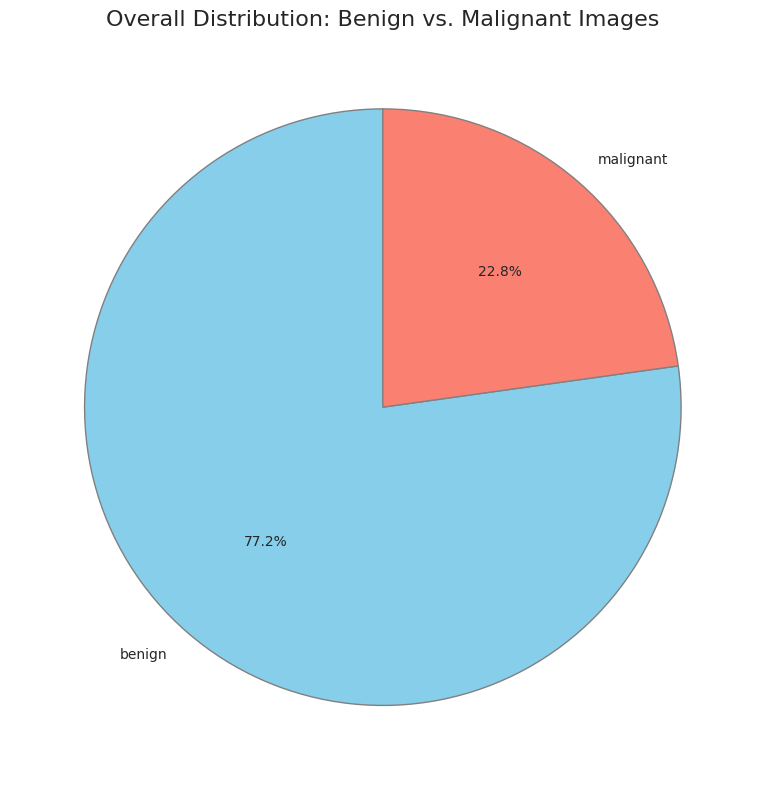


Dataset Contribution to Benign and Malignant Classes:
binary_label_str  benign  malignant
dataset                            
HAM10000            7000       1203
ISIC                1022       1165


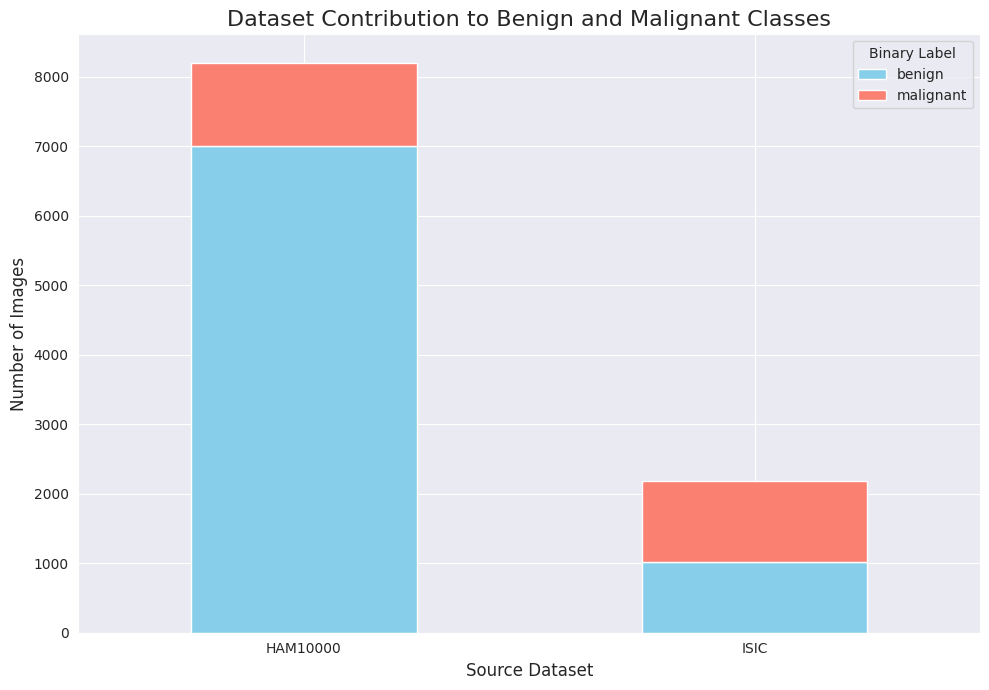


Final Distribution of Original Multi-Class Labels (for reference):
original_label_multiclass
NV                         6385
MEL                        1077
BKL                         604
benign keratosis            481
melanoma                    447
basal cell carcinoma        391
nevus                       289
squamous cell carcinoma     197
vascular lesion             141
actinic keratosis           130
BCC                         120
dermatofibroma              111
DF                           11
AKIEC                         6
Name: count, dtype: int64

Final Distribution of ISIC Splits (HAM10000 is 'Unknown'):
split
Unknown    8203
Train      2069
Test        118
Name: count, dtype: int64

Missing values per column in de-duplicated binary data:
filepath                        0
original_label_multiclass       0
binary_label_str                0
binary_label_int                0
dataset                         0
split                           0
original_image_id            21

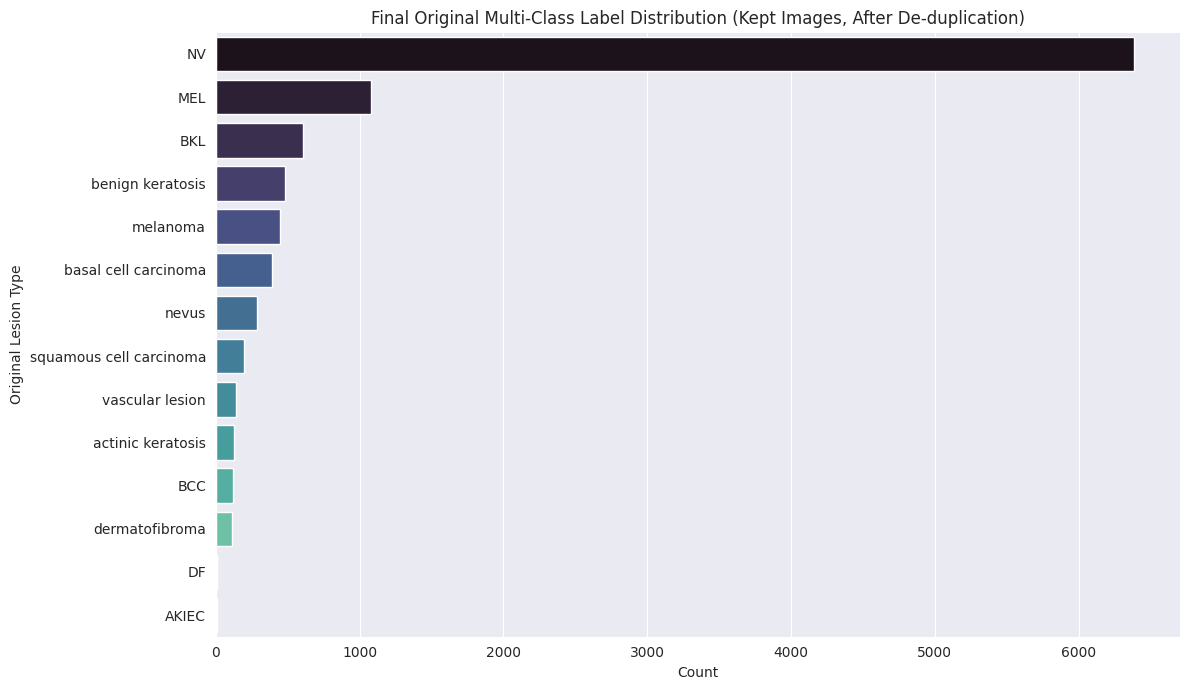

In [11]:

# Cell 11: Analyze De-duplicated Binary Data (Revised for Focused Binary EDA)

print("\n--- EDA on De-duplicated BINARY Data ---")

if 'deduplicated_binary_df' in locals() and not deduplicated_binary_df.empty:
    df_eda = deduplicated_binary_df.copy() # Work on a copy for EDA modifications

    print(f"Total number of unique images after de-duplication: {len(df_eda)}")

    # 1. Overall Benign vs. Malignant Distribution
    print("\nFinal Distribution of BINARY Labels (benign/malignant):")
    final_binary_label_counts = df_eda['binary_label_str'].value_counts()
    print(final_binary_label_counts)

    # Pie chart for Benign vs. Malignant
    plt.figure(figsize=(8, 8))
    final_binary_label_counts.plot.pie(
        autopct='%1.1f%%', # Format for percentage display
        startangle=90,
        colors=['skyblue', 'salmon'], # Example colors
        wedgeprops={'edgecolor': 'grey'}
    )
    plt.title('Overall Distribution: Benign vs. Malignant Images', fontsize=16)
    plt.ylabel('') # Hide the default 'binary_label_str' ylabel
    plt.tight_layout()
    plt.show()


    # 2. Dataset Contribution to Benign and Malignant Classes
    print("\nDataset Contribution to Benign and Malignant Classes:")
    # Group by dataset and then by binary label, then count
    contribution_counts = df_eda.groupby(['dataset', 'binary_label_str']).size().unstack(fill_value=0)
    print(contribution_counts)

    # Stacked Bar Chart for Dataset Contribution
    contribution_counts.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 7),
        color=['skyblue', 'salmon'] # Colors for benign, malignant
    )
    plt.title('Dataset Contribution to Benign and Malignant Classes', fontsize=16)
    plt.xlabel('Source Dataset', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=0) # Keep dataset names horizontal
    plt.legend(title='Binary Label')
    plt.tight_layout()
    plt.show()

    # 3. Other Useful Info (can be kept from previous version if desired)
    print("\nFinal Distribution of Original Multi-Class Labels (for reference):")
    final_original_multiclass_counts = df_eda['original_label_multiclass'].value_counts()
    print(final_original_multiclass_counts)

    print("\nFinal Distribution of ISIC Splits (HAM10000 is 'Unknown'):")
    final_split_counts = df_eda['split'].value_counts() # 'split' column from your df
    print(final_split_counts)

    print("\nMissing values per column in de-duplicated binary data:")
    print(df_eda.isnull().sum())

    
    print("\nFinal Distribution of Original Multi-Class Labels (for reference):")
    # This shows the distribution of the original, more granular classes that were kept
    final_original_multiclass_counts = deduplicated_binary_df['original_label_multiclass'].value_counts()
    print(final_original_multiclass_counts)
  
    # Original Multi-Class Label distribution plot (for reference)
    plt.figure(figsize=(12, 7))
    sns.countplot(data=deduplicated_binary_df, y='original_label_multiclass', order=final_original_multiclass_counts.index, palette='mako')
    plt.title('Final Original Multi-Class Label Distribution (Kept Images, After De-duplication)')
    plt.xlabel('Count')
    plt.ylabel('Original Lesion Type')
    plt.tight_layout()
    plt.show()


else:
    print("Error: 'deduplicated_binary_df' is not defined or is empty. Cannot perform EDA.")

# **Section 6: Data Balancing & Splitting**


--- Data Balancing: Undersampling Benign Class (Focusing on Nevus) ---
Before Undersampling: Malignant = 2368, Benign = 8022
Benign samples: Total Nevus (NV/nevus) = 6674, Other Benign = 1348
Target number of Nevus (NV/nevus) samples to keep: 1256
Undersampled Nevus from 6674 to 1256

After Undersampling:
Total samples: 4972
binary_label_str
benign       2604
malignant    2368
Name: count, dtype: int64


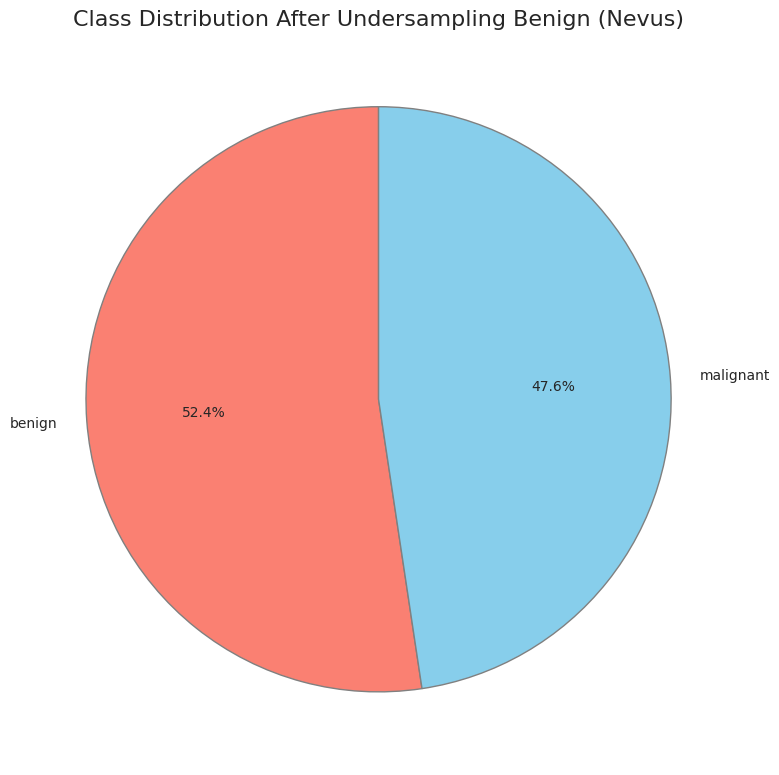


New distribution of original multi-class labels in the balanced set:
original_label_multiclass
NV                         1192
MEL                        1077
BKL                         604
benign keratosis            481
melanoma                    447
basal cell carcinoma        391
squamous cell carcinoma     197
vascular lesion             141
actinic keratosis           130
BCC                         120
dermatofibroma              111
nevus                        64
DF                           11
AKIEC                         6
Name: count, dtype: int64


In [12]:
# Cell 12: Undersampling Benign Class (Targeting Nevus)
from sklearn.utils import resample # For random sampling

print("\n--- Data Balancing: Undersampling Benign Class (Focusing on Nevus) ---")

if 'deduplicated_binary_df' in locals() and not deduplicated_binary_df.empty:
    df_to_balance = deduplicated_binary_df.copy()

    # --- Identify current counts ---
    count_malignant = df_to_balance[df_to_balance['binary_label_str'] == 'malignant'].shape[0]
    count_benign = df_to_balance[df_to_balance['binary_label_str'] == 'benign'].shape[0]
    print(f"Before Undersampling: Malignant = {count_malignant}, Benign = {count_benign}")

    # --- Separate malignant and benign samples ---
    df_malignant = df_to_balance[df_to_balance['binary_label_str'] == 'malignant']
    df_benign = df_to_balance[df_to_balance['binary_label_str'] == 'benign']

    is_nevus_mask = df_benign['original_label_multiclass'].isin(['NV', 'nevus'])
    df_benign_nevus = df_benign[is_nevus_mask]
    df_benign_other = df_benign[~is_nevus_mask]

    print(f"Benign samples: Total Nevus (NV/nevus) = {len(df_benign_nevus)}, Other Benign = {len(df_benign_other)}")

    # --- Determine undersampling target ---
    # Option 1: Make total benign count equal to malignant count
    # target_benign_nevus_count = count_malignant - len(df_benign_other)
    
    # Option 2: A less aggressive undersampling, e.g., reduce Nevus significantly but keep total benign > malignant
    # Let's aim to reduce Nevus so total benign is closer to, say, 1.5x to 2x malignant count, or simply match malignant.
    # For a more balanced dataset, let's aim for total benign to be roughly equal to malignant.
    # This means the number of Nevus samples we keep will be:
    # target_benign_nevus_count = max(0, count_malignant - len(df_benign_other))
    
    # Let's try to make the number of Nevus samples such that total benign matches malignant.
    # However, if 'other benign' is already >= malignant, we might not need any nevus, or just a few.
    # A simpler approach: decide how many 'Nevus' to keep. Let's say we want to keep 500 Nevus instances.
    # Or, let's be more dynamic: reduce Nevus so that its count is, for example, no more than the next largest benign category.
    # The next largest original benign categories are BKL (604) and benign keratosis (481).

    n_nevus_to_keep = 1256

    n_nevus_to_keep = max(0, n_nevus_to_keep)
    n_nevus_to_keep = min(n_nevus_to_keep, len(df_benign_nevus))

    print(f"Target number of Nevus (NV/nevus) samples to keep: {n_nevus_to_keep}")

    if len(df_benign_nevus) > n_nevus_to_keep:
        df_benign_nevus_undersampled = resample(
            df_benign_nevus,
            replace=False, # No replacement, we are undersampling
            n_samples=n_nevus_to_keep,
            random_state=SEED # from Cell 3, for reproducibility
        )
        print(f"Undersampled Nevus from {len(df_benign_nevus)} to {len(df_benign_nevus_undersampled)}")
    else:
        df_benign_nevus_undersampled = df_benign_nevus # Keep all if already less than or equal to target
        print(f"No undersampling needed for Nevus, keeping all {len(df_benign_nevus)} samples.")

    # --- Combine undersampled Nevus with other benign samples ---
    df_benign_balanced = pd.concat([df_benign_nevus_undersampled, df_benign_other])

    # --- Combine balanced benign with all malignant samples ---
    df_balanced = pd.concat([df_malignant, df_benign_balanced])

    # --- Shuffle the final balanced DataFrame ---
    df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

    print(f"\nAfter Undersampling:")
    print(f"Total samples: {len(df_balanced)}")
    final_balanced_counts = df_balanced['binary_label_str'].value_counts()
    print(final_balanced_counts)

    # --- Visualize new distribution ---
    plt.figure(figsize=(8, 8))
    final_balanced_counts.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=['salmon', 'skyblue'], # Malignant, Benign
        wedgeprops={'edgecolor': 'grey'}
    )
    plt.title('Class Distribution After Undersampling Benign (Nevus)', fontsize=16)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    print("\nNew distribution of original multi-class labels in the balanced set:")
    print(df_balanced['original_label_multiclass'].value_counts())

else:
    print("Error: 'deduplicated_binary_df' is not defined or is empty. Cannot perform undersampling.")
    df_balanced = pd.DataFrame() # Ensure df_balanced is defined



--- Splitting the BALANCED data into Train, Validation, and Test sets ---

Balanced dataset total samples: 4972
Train set shape: (3480, 8)
Validation set shape: (746, 8)
Test set shape: (746, 8)

Label distribution in Train set (binary_label_str):
binary_label_str
benign       0.523851
malignant    0.476149
Name: proportion, dtype: float64

Label distribution in Validation set (binary_label_str):
binary_label_str
benign       0.522788
malignant    0.477212
Name: proportion, dtype: float64

Label distribution in Test set (binary_label_str):
binary_label_str
benign       0.524129
malignant    0.475871
Name: proportion, dtype: float64


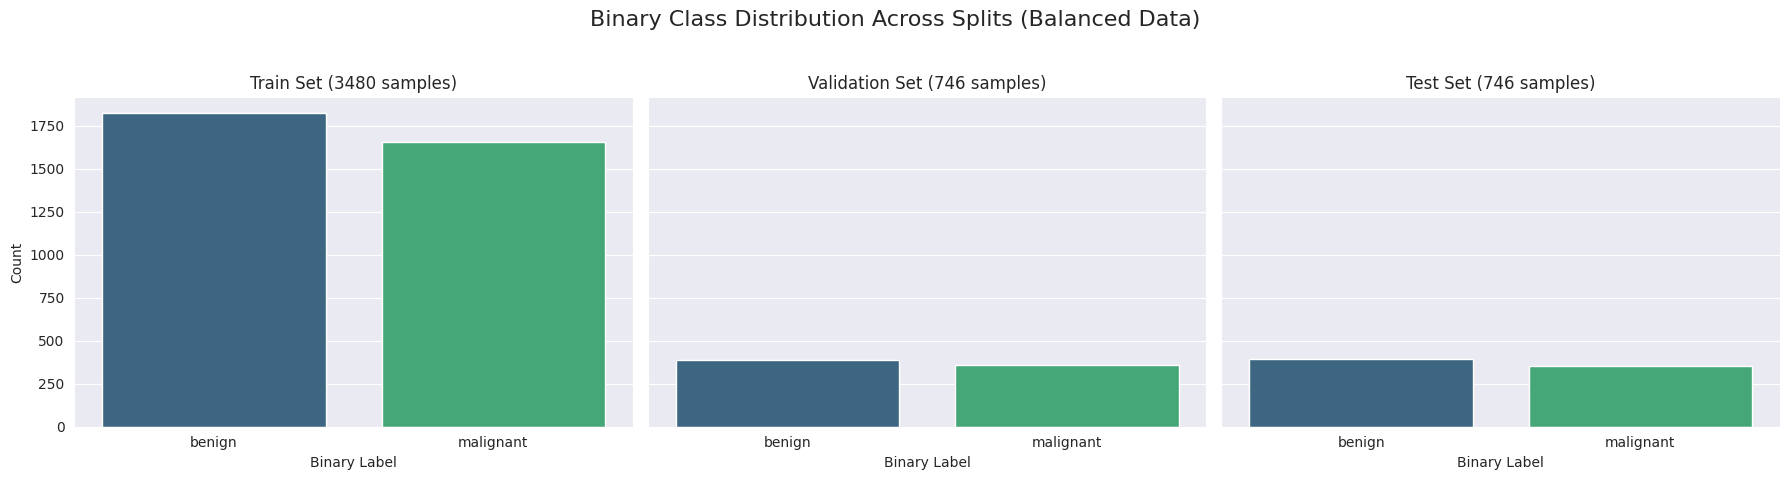

In [13]:
# Cell 13: Split Balanced Data into Train, Validation, and Test Sets
from sklearn.model_selection import train_test_split

print("\n--- Splitting the BALANCED data into Train, Validation, and Test sets ---")

if 'df_balanced' in locals() and not df_balanced.empty:
    # --- Define Split Ratios ---
    # For example: 70% Train, 15% Validation, 15% Test
    # Or 80% Train, 10% Validation, 10% Test
    TRAIN_RATIO = 0.70
    # The remaining will be split 50/50 for validation and test
    # TRAIN_RATIO = 0.70, VAL_RATIO = 0.15, TEST_RATIO = 0.15

    TEMP_SET_RATIO = 1.0 - TRAIN_RATIO # Proportion for (Validation + Test)

    # Step 1: Split into Training and Temp (Val + Test combined)
    # We are using df_balanced from the undersampling step (Cell 12)
    train_df, temp_df = train_test_split(
        df_balanced, 
        test_size=TEMP_SET_RATIO,
        random_state=SEED,
        stratify=df_balanced['binary_label_str'] # Stratify based on the binary label
    )

    # Step 2: Split Temp into Validation and Test (50/50 split of temp_df)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50, # Split the temp_df into 50% validation, 50% test
        random_state=SEED, # Use the same seed for consistency
        stratify=temp_df['binary_label_str'] # Stratify again
    )

    # --- Verify Split Shapes and Distributions ---
    print(f"\nBalanced dataset total samples: {len(df_balanced)}")
    print(f"Train set shape: {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape: {test_df.shape}")

    print("\nLabel distribution in Train set (binary_label_str):")
    print(train_df['binary_label_str'].value_counts(normalize=True).sort_index())

    print("\nLabel distribution in Validation set (binary_label_str):")
    print(val_df['binary_label_str'].value_counts(normalize=True).sort_index())

    print("\nLabel distribution in Test set (binary_label_str):")
    print(test_df['binary_label_str'].value_counts(normalize=True).sort_index())

    # --- Visualize Split Distributions for Binary Labels ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True) # sharey can be True or False
    fig.suptitle('Binary Class Distribution Across Splits (Balanced Data)', fontsize=16)

    # Get the order of binary labels for consistent plotting
    binary_order = sorted(df_balanced['binary_label_str'].unique())

    sns.countplot(ax=axes[0], data=train_df, x='binary_label_str', order=binary_order, palette='viridis')
    axes[0].set_title(f'Train Set ({len(train_df)} samples)')
    axes[0].set_xlabel('Binary Label')
    axes[0].set_ylabel('Count')

    sns.countplot(ax=axes[1], data=val_df, x='binary_label_str', order=binary_order, palette='viridis')
    axes[1].set_title(f'Validation Set ({len(val_df)} samples)')
    axes[1].set_xlabel('Binary Label')
    axes[1].set_ylabel('') # Hide y-label if sharey=True

    sns.countplot(ax=axes[2], data=test_df, x='binary_label_str', order=binary_order, palette='viridis')
    axes[2].set_title(f'Test Set ({len(test_df)} samples)')
    axes[2].set_xlabel('Binary Label')
    axes[2].set_ylabel('') # Hide y-label if sharey=True

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("Error: 'df_balanced' is not defined or is empty. Cannot perform data splitting.")
    # Define empty dataframes to prevent errors in subsequent cells if this fails
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()

# **Section 7: Dataset & DataLoader Implementation**

In [14]:
# Section 7 (Replacement): Creating tf.data.Datasets for Training, Validation, and Test

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import pandas as pd # Make sure pandas is imported if train_df etc. are DataFrames

# Ensure IMG_SIZE, BATCH_SIZE, SEED are defined globally (e.g., from Cell 3)
# Example:
# IMG_SIZE = 224
# BATCH_SIZE = 32
# SEED = 42

print("\n--- Creating tf.data.Datasets from DataFrames ---")

# Helper function to parse image and labels
def load_and_preprocess_image(image_path, label, augment=False):
    # Read image file
    image = tf.io.read_file(image_path)
    # Decode image to tensor, ensure 3 channels
    image = tf.image.decode_image(image, channels=3, expand_animations=False) # Handles jpg, png etc.
    # Resize image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) # IMG_SIZE must be defined
    
    # Data Augmentation (only for training)
    if augment:
        image = tf.image.random_flip_left_right(image, seed=SEED) # SEED for reproducibility
        image = tf.image.random_flip_up_down(image, seed=SEED)   # SEED for reproducibility    
        image = tf.image.random_brightness(image, max_delta=0.1, seed=SEED)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1, seed=SEED)
        # Note: For rotations, tf.keras.layers.RandomRotation applied after batching or tfa.image.rotate are options.

    # Apply VGG16 specific preprocessing
    image = vgg16_preprocess_input(tf.cast(image, tf.float32)) # vgg16_preprocess_input expects float32
    return image, label

# Helper function to create a tf.data.Dataset from a DataFrame
def dataframe_to_tf_dataset(dataframe, shuffle_flag=True, augment_flag=False, repeat_flag=True): # repeat_flag default True
    if dataframe is None or dataframe.empty:
        print(f"Warning: DataFrame is None or empty. Returning None for tf.data.Dataset.")
        return None
        
    df = dataframe.copy()
    # Create a mapping from string labels to integers
    label_map = {'benign': 0, 'malignant': 1} # Ensure this matches your classes
    df['label_int'] = df['binary_label_str'].map(label_map)
    
    # Check for any NaN labels after mapping
    if df['label_int'].isnull().any():
        print("Warning: Found NaN values in 'label_int' after mapping. Problematic 'binary_label_str' values:")
        print(df[df['label_int'].isnull()]['binary_label_str'].value_counts())
        df.dropna(subset=['label_int'], inplace=True) # Drop rows with unmapped labels
        print(f"Rows remaining after dropping NaNs from labels: {len(df)}")
        if df.empty:
            print("DataFrame became empty after dropping NaN labels. Cannot create dataset.")
            return None

    filepaths = df['filepath'].values
    labels = df['label_int'].astype(np.int32).values

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    if shuffle_flag: # Typically True for training, False for val/test
        dataset = dataset.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)
        
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment=augment_flag),
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE) # BATCH_SIZE must be defined
    
    if repeat_flag: # Training, validation, and test datasets will all repeat
                    # Iteration is controlled by steps_per_epoch, validation_steps, and test_steps
        dataset = dataset.repeat()
        
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Create tf.data.Dataset instances ---
# train_df, val_df, test_df should be defined from Cell 13 (Data Splitting)
# These DataFrames are used here to get lengths for calculating steps later.

# For training: shuffle=True, augment=True, repeat=True
train_dataset_tf = dataframe_to_tf_dataset(train_df, shuffle_flag=True, augment_flag=True, repeat_flag=True)

# For validation: shuffle=False, augment=False, repeat=True (iteration controlled by validation_steps)
val_dataset_tf = dataframe_to_tf_dataset(val_df, shuffle_flag=False, augment_flag=False, repeat_flag=True)

# For test: shuffle=False, augment=False, repeat=True (iteration controlled by test_steps for evaluation)
test_dataset_tf = dataframe_to_tf_dataset(test_df, shuffle_flag=False, augment_flag=False, repeat_flag=True)


if train_dataset_tf: print(f"Training tf.data.Dataset created. Type: {type(train_dataset_tf)}")
else: print("Training tf.data.Dataset FAILED to create.")

if val_dataset_tf: print(f"Validation tf.data.Dataset created. Type: {type(val_dataset_tf)}")
else: print("Validation tf.data.Dataset FAILED to create.")

if test_dataset_tf: print(f"Test tf.data.Dataset created. Type: {type(test_dataset_tf)}")
else: print("Test tf.data.Dataset FAILED to create.")


# --- Test one batch from train_dataset_tf ---
if train_dataset_tf:
    try:
        print("\nFetching one batch from train_dataset_tf...")
        for images_batch_tf, labels_batch_tf in train_dataset_tf.take(1): # .take(1) gets one batch
            print(f"  TF.data Images batch shape: {images_batch_tf.shape}")
            print(f"  TF.data Labels batch shape: {labels_batch_tf.shape}")
            print(f"  TF.data Labels batch dtype: {labels_batch_tf.dtype}") # Should be int32
            print(f"  TF.data Labels batch sample (first 5): {labels_batch_tf.numpy()[:5]}")
            print(f"  Image batch min/max values: {tf.reduce_min(images_batch_tf).numpy()}, {tf.reduce_max(images_batch_tf).numpy()}")
    except Exception as e:
        print(f"Error fetching batch from train_dataset_tf: {e}")
else:
    print("\nSkipping batch fetching as train_dataset_tf is not available.")


--- Creating tf.data.Datasets from DataFrames ---


I0000 00:00:1748079053.735282      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748079053.736029      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training tf.data.Dataset created. Type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Validation tf.data.Dataset created. Type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Test tf.data.Dataset created. Type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>

Fetching one batch from train_dataset_tf...
  TF.data Images batch shape: (32, 224, 224, 3)
  TF.data Labels batch shape: (32,)
  TF.data Labels batch dtype: <dtype: 'int32'>
  TF.data Labels batch sample (first 5): [1 1 1 0 1]
  Image batch min/max values: -128.73904418945312, 154.96298217773438


#  **Section 8: Base Model Definition (VGG16 + Vit)**

In [15]:
# Cell 16: Install and Import timm
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Conv2D, Reshape, Add, Embedding, GlobalAveragePooling1D, Input, Flatten
)
from tensorflow.keras import backend as K # Used for K.int_shape

In [16]:
# Cell for CNN-ViT Model Building Blocks (e.g., Cell 17)

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Conv2D, Reshape, Add, Embedding, GlobalAveragePooling1D, Input, Flatten
)
from tensorflow.keras import backend as K

# --- Helper: MLP Block for Transformer ---
def mlp_block(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

# --- Helper: Transformer Encoder Block ---
def transformer_encoder_block(inputs, num_heads, projection_dim, mlp_dim, dropout_rate):
    x1 = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=projection_dim // num_heads,
        dropout=dropout_rate
    )(x1, x1)
    x2 = Add()([attention_output, inputs])
    x3 = LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp_block(x3, hidden_units=[mlp_dim, projection_dim], dropout_rate=dropout_rate)
    outputs = Add()([x3, x2])
    return outputs

# --- Custom Layer for Positional Embedding ---
class PositionEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding_layer = Embedding(
            input_dim=self.num_patches,
            output_dim=self.projection_dim,
            embeddings_initializer="zeros"
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, inputs):
        embedded_positions = self.position_embedding_layer(self.positions)
        return inputs + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

# --- Main Function: Building the CCN-ViT Model ---
def build_ccn_vit_model(
    img_shape,
    class_counts,
    projection_dim,
    num_transformer_layers,
    num_heads,
    transformer_mlp_dim,
    vit_dropout_rate,
    mlp_head_units,
    mlp_head_dropout
):
    inputs = Input(shape=img_shape, name="input_image")
    base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    print(f"VGG16 total layers (before our additions): {len(base_model_vgg.layers)}")
    for layer_idx, layer in enumerate(base_model_vgg.layers):
        if layer_idx < 15:
            layer.trainable = False
        else:
            layer.trainable = True

    try:
        cnn_features = base_model_vgg.get_layer('block5_conv3').output
    except ValueError:
        print("Warning: 'block5_conv3' not found by name. Using base_model_vgg.output instead.")
        cnn_features = base_model_vgg.output

    feature_map_height = K.int_shape(cnn_features)[1]
    feature_map_width = K.int_shape(cnn_features)[2]
    if feature_map_height is None or feature_map_width is None:
        raise ValueError("Feature map dimensions are None. Check VGG16 output.")

    patches = Conv2D(
        filters=projection_dim,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        name="patch_projection",
        kernel_initializer="lecun_normal"
    )(cnn_features)

    num_patches = feature_map_height * feature_map_width
    patches_reshaped = Reshape((num_patches, projection_dim), name="patches_reshaped")(patches)

    encoded_patches = PositionEmbedding(num_patches, projection_dim, name="position_embedding_layer")(patches_reshaped)
    encoded_patches = Dropout(vit_dropout_rate, name="vit_embedding_dropout")(encoded_patches)

    transformer_output = encoded_patches
    for i in range(num_transformer_layers):
        transformer_output = transformer_encoder_block(
            transformer_output, num_heads, projection_dim, transformer_mlp_dim, vit_dropout_rate
        )
        transformer_output = LayerNormalization(epsilon=1e-6, name=f"transformer_block_{i}_output_norm")(transformer_output)

    representation = GlobalAveragePooling1D(name="gap_transformer_outputs")(transformer_output)
    x_head = representation
    for units_idx, units in enumerate(mlp_head_units):
        x_head = Dense(units, activation='relu', name=f"mlp_head_dense_{units_idx}")(x_head)
        x_head = Dropout(mlp_head_dropout, name=f"mlp_head_dropout_{units_idx}")(x_head)

    outputs = Dense(class_counts, activation="sigmoid", name="classifier_output")(x_head)
    model = Model(inputs=inputs, outputs=outputs, name="CNN_ViT_SkinCancer_v3") # Ensure unique model name
    return model

print("CNN-ViT Model building blocks and function defined (with custom PositionEmbedding layer).")

CNN-ViT Model building blocks and function defined (with custom PositionEmbedding layer).


In [17]:
# Section 8: CNN-ViT Model Definition and Compilation

IMG_HEIGHT = IMG_SIZE 
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 3
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

CLASS_COUNTS = 1 # For binary classification

PROJECTION_DIM = 128
NUM_TRANSFORMER_LAYERS = 4
NUM_HEADS = 4
TRANSFORMER_MLP_DIM = PROJECTION_DIM * 2
VIT_DROPOUT_RATE = 0.1
MLP_HEAD_UNITS = [64, 32]
MLP_HEAD_DROPOUT = 0.2
LEARNING_RATE = 0.0001 # Or 1e-4

# --- Build the CNN-ViT Model ---
print("\n--- Building the CNN-ViT Model ---")
# build_ccn_vit_model function should be defined in a previous cell (e.g., Cell 17)
ccn_vit_model = build_ccn_vit_model(
    img_shape=img_shape,
    class_counts=CLASS_COUNTS,
    projection_dim=PROJECTION_DIM,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    num_heads=NUM_HEADS,
    transformer_mlp_dim=TRANSFORMER_MLP_DIM,
    vit_dropout_rate=VIT_DROPOUT_RATE,
    mlp_head_units=MLP_HEAD_UNITS,
    mlp_head_dropout=MLP_HEAD_DROPOUT
)

# --- Compile the Model ---
optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Alternative

ccn_vit_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy', # For binary classification with sigmoid output
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("\nCNN-ViT Model Summary:")
ccn_vit_model.summary()


--- Building the CNN-ViT Model ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 total layers (before our additions): 19

CNN-ViT Model Summary:


Model: "CNN_ViT_SkinCancer_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 15,346,753 (58.54 MB)

 Trainable params: 7,711,489 (29.42 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# **Section 9: Model Training and Evaluation**



--- Starting Model Training (with tf.data.Dataset) ---
Using tf.data.Dataset: steps_per_epoch = 109, validation_steps = 24
Epoch 1/30


I0000 00:00:1748079078.474014      69 service.cc:148] XLA service 0x7b1bac0022d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748079078.476195      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748079078.476220      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748079080.456711      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748079106.696797      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6243 - auc: 0.6885 - loss: 0.6260 - precision: 0.5975 - recall: 0.5671
Epoch 1: val_auc improved from -inf to 0.81328, saving model to /kaggle/working/ccn_vit_binary_tfdata_best_v2.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 112s 586ms/step - accuracy: 0.6246 - auc: 0.6887 - loss: 0.6258 - precision: 0.5978 - recall: 0.5680 - val_accuracy: 0.7091 - val_auc: 0.8133 - val_loss: 0.5253 - val_precision: 0.6334 - val_recall: 0.9270 - learning_rate: 1.0000e-04
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6983 - auc: 0.7758 - loss: 0.5517 - precision: 0.6616 - recall: 0.7692
Epoch 2: val_auc improved from 0.81328 to 0.81766, saving model to /kaggle/working/ccn_vit_binary_tfdata_best_v2.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.6983 - auc: 0.7759 - loss: 0.5517 - precision: 0.6617 - recall: 0.7691 - val_accuracy: 0.7158 - val_auc: 0.8177 - val_loss: 0.5064 - val_precision: 0.7069 - val_recall: 0.6910 -

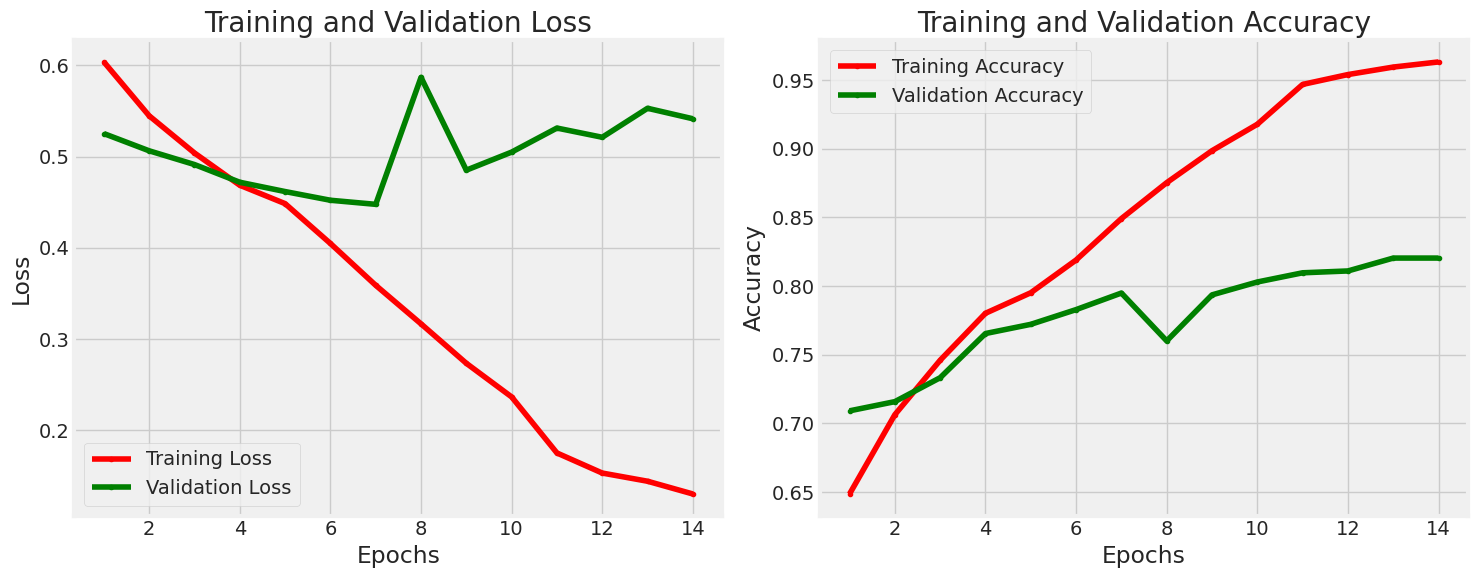


--- Final Model Evaluation (using tf.data.Dataset) ---

--- Evaluating Model on Training Set ---
Evaluation steps for Training Set: 109
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.8923 - auc: 0.9487 - loss: 0.2827 - precision: 0.8557 - recall: 0.9336

Training Set Results:
  loss: 0.2761
  compile_metrics: 0.8925

--- Evaluating Model on Validation Set ---
Evaluation steps for Validation Set: 24
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8065 - auc: 0.8878 - loss: 0.4334 - precision: 0.8118 - recall: 0.7915

Validation Set Results:
  loss: 0.4477
  compile_metrics: 0.7949

--- Evaluating Model on Test Set ---
Evaluation steps for Test Set: 24
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.7962 - auc: 0.8916 - loss: 0.4224 - precision: 0.7493 - recall: 0.8462

Test Set Results:
  loss: 0.4145
  compile_metrics: 0.8056

--- Confusion Matrix and Classification Report for Test Set ---
Extracting true labels for CM from Test Set using 24 steps.
Predicting 

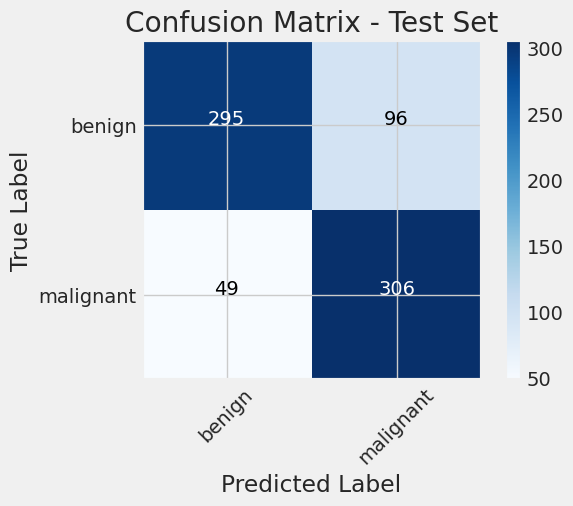


Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.75      0.80       391
   malignant       0.76      0.86      0.81       355

    accuracy                           0.81       746
   macro avg       0.81      0.81      0.81       746
weighted avg       0.81      0.81      0.81       746


Loading best saved model for final evaluation (based on val_auc)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'position_embedding_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Best model loaded from ModelCheckpoint.

--- Evaluating Model on Test Set (Best Model) ---
Evaluation steps for Test Set (Best Model): 24
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.8198 - auc: 0.9059 - loss: 0.4624 - precision: 0.8053 - recall: 0.8092

Test Set (Best Model) Results:
  loss: 0.4692
  compile_metrics: 0.8190

--- Confusion Matrix and Classification Report for Test Set (Best Model) ---
Extracting true labels for CM from Test Set (Best Model) using 24 steps.
Predicting on Test Set (Best Model) using 24 steps for CM.
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step


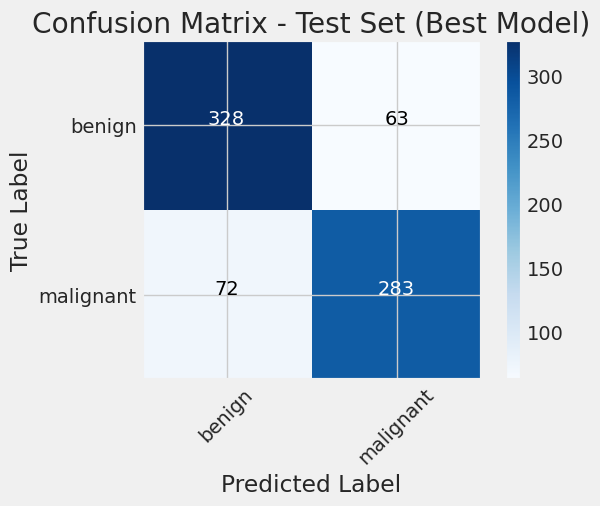


Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.84      0.83       391
   malignant       0.82      0.80      0.81       355

    accuracy                           0.82       746
   macro avg       0.82      0.82      0.82       746
weighted avg       0.82      0.82      0.82       746



In [18]:
# Section 9: Model Training and Evaluation (Adapted for tf.data.Dataset)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
import itertools
import pandas as pd # Assuming train_df, val_df, test_df are pandas DataFrames for getting len()

# --- Define Model Performance and Evaluation Functions ---
def model_performance_plots(history):
    # Using .get() for safety in case a metric was not recorded
    tr_acc = history.history.get('accuracy', [])
    tr_loss = history.history.get('loss', [])
    val_acc = history.history.get('val_accuracy', [])
    val_loss = history.history.get('val_loss', [])

    if not tr_loss or not val_loss or not tr_acc or not val_acc:
        print("Warning: One or more metric lists are empty in history. Cannot plot.")
        return
        
    num_epochs_to_plot = min(len(tr_loss), len(val_loss), len(tr_acc), len(val_acc))
    if num_epochs_to_plot == 0:
        print("Warning: No common epochs to plot. History might be empty or mismatched.")
        return
        
    epochs_range = range(1, num_epochs_to_plot + 1)
    tr_loss, val_loss = tr_loss[:num_epochs_to_plot], val_loss[:num_epochs_to_plot]
    tr_acc, val_acc = tr_acc[:num_epochs_to_plot], val_acc[:num_epochs_to_plot]
    
    print(f"Plotting performance for {num_epochs_to_plot} epochs.")
    plt.figure(figsize=(15, 6))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tr_loss, 'r.-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'g.-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tr_acc, 'r.-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'g.-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

def evaluate_model_with_tf_dataset(model, dataset_name, tf_dataset_eval, num_samples_eval, batch_size_eval):
    print(f"\n--- Evaluating Model on {dataset_name} ---")
    if tf_dataset_eval is None:
        print(f"{dataset_name} tf.data.Dataset not available. Skipping evaluation.")
        return [0]*(len(model.metrics_names)) if hasattr(model, 'metrics_names') else [0,0]

    # For a repeating dataset, steps must be provided to evaluate once
    steps_to_eval = int(np.ceil(num_samples_eval / batch_size_eval))
    print(f"Evaluation steps for {dataset_name}: {steps_to_eval}")
    
    eval_results = model.evaluate(tf_dataset_eval, steps=steps_to_eval, verbose=1)
    
    print(f"\n{dataset_name} Results:")
    metric_names = model.metrics_names
    for name, value in zip(metric_names, eval_results):
        print(f"  {name}: {value:.4f}")
    return eval_results

def plot_binary_confusion_matrix_tf_dataset(model, tf_dataset_for_cm, num_samples_cm, batch_size_cm, dataset_name="Test Set"):
    print(f"\n--- Confusion Matrix and Classification Report for {dataset_name} ---")
    if tf_dataset_for_cm is None:
        print(f"{dataset_name} tf.data.Dataset not available. Skipping CM.")
        return

    y_true_list_cm = []
    # For a repeating dataset, steps must be provided to iterate once
    steps_for_cm_data_extraction = int(np.ceil(num_samples_cm / batch_size_cm))
    print(f"Extracting true labels for CM from {dataset_name} using {steps_for_cm_data_extraction} steps.")

    for _, labels_batch_cm in tf_dataset_for_cm.take(steps_for_cm_data_extraction):
        y_true_list_cm.extend(labels_batch_cm.numpy())
    y_true_cm = np.array(y_true_list_cm)[:num_samples_cm]

    print(f"Predicting on {dataset_name} using {steps_for_cm_data_extraction} steps for CM.")
    y_pred_probs_cm = model.predict(tf_dataset_for_cm, steps=steps_for_cm_data_extraction, verbose=1)
    y_pred_probs_cm = y_pred_probs_cm[:num_samples_cm]
    y_pred_classes_cm = (y_pred_probs_cm > 0.5).astype(int).flatten()

    if len(y_true_cm) != len(y_pred_classes_cm):
        print(f"Warning: Length mismatch for CM. True labels: {len(y_true_cm)}, Pred classes: {len(y_pred_classes_cm)}")
        # This can happen if num_samples is not perfectly divisible by batch_size and take/predict handles it differently.
        # Try to align them:
        min_len = min(len(y_true_cm), len(y_pred_classes_cm))
        y_true_cm = y_true_cm[:min_len]
        y_pred_classes_cm = y_pred_classes_cm[:min_len]
        print(f"Adjusted lengths to: {min_len}")

    class_names = ['benign', 'malignant'] 
    cm = confusion_matrix(y_true_cm, y_pred_classes_cm)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {dataset_name}'); plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45); plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

    print("\nClassification Report:"); print(classification_report(y_true_cm, y_pred_classes_cm, target_names=class_names, zero_division=0))

# --- Training Parameters ---
EPOCHS = 30 # Adjust as needed
MODEL_SAVE_PATH = "/kaggle/working/ccn_vit_binary_tfdata_best_v2.keras" # New save path

# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH, save_best_only=True, monitor='val_auc', mode='max', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# --- Train the Model ---
print("\n--- Starting Model Training (with tf.data.Dataset) ---")
# train_df, val_df, test_df are pandas DataFrames used for getting lengths.
# BATCH_SIZE is a global constant.
# train_dataset_tf, val_dataset_tf, test_dataset_tf are the tf.data.Dataset objects.

if all(ds is not None for ds in [train_dataset_tf, val_dataset_tf, test_dataset_tf]) and \
   all(df is not None for df in [train_df, val_df, test_df]):
    
    steps_per_epoch_tf = int(np.ceil(len(train_df) / BATCH_SIZE))
    validation_steps_tf = int(np.ceil(len(val_df) / BATCH_SIZE))

    print(f"Using tf.data.Dataset: steps_per_epoch = {steps_per_epoch_tf}, validation_steps = {validation_steps_tf}")

    history = ccn_vit_model.fit(
        train_dataset_tf,
        epochs=EPOCHS,
        validation_data=val_dataset_tf,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch_tf,
        validation_steps=validation_steps_tf
    )

    # --- Post-Training Evaluation ---
    print("\n--- Training Finished. Evaluating Model ---")
    model_performance_plots(history)

    print("\n--- Final Model Evaluation (using tf.data.Dataset) ---")
    # Note: For the training set evaluation, because train_dataset_tf repeats and shuffles,
    # we evaluate on a non-shuffled, non-repeating version if available, or accept that the
    # training metrics from model.evaluate here will be on one pass of possibly shuffled data.
    # For simplicity, we use the repeating train_dataset_tf but with defined steps.
    evaluate_model_with_tf_dataset(ccn_vit_model, "Training Set", train_dataset_tf, len(train_df), BATCH_SIZE)
    evaluate_model_with_tf_dataset(ccn_vit_model, "Validation Set", val_dataset_tf, len(val_df), BATCH_SIZE)
    evaluate_model_with_tf_dataset(ccn_vit_model, "Test Set", test_dataset_tf, len(test_df), BATCH_SIZE)

    plot_binary_confusion_matrix_tf_dataset(ccn_vit_model, test_dataset_tf, len(test_df), BATCH_SIZE, dataset_name="Test Set")
    
    print("\nLoading best saved model for final evaluation (based on val_auc)...")
    try:
        best_model = tf.keras.models.load_model(MODEL_SAVE_PATH, custom_objects={'PositionEmbedding': PositionEmbedding})
        print("Best model loaded from ModelCheckpoint.")
        evaluate_model_with_tf_dataset(best_model, "Test Set (Best Model)", test_dataset_tf, len(test_df), BATCH_SIZE)
        plot_binary_confusion_matrix_tf_dataset(best_model, test_dataset_tf, len(test_df), BATCH_SIZE, dataset_name="Test Set (Best Model)")
    except Exception as e:
        print(f"Could not load or evaluate best model from {MODEL_SAVE_PATH}: {e}")
        print("This might happen if no model was saved (e.g., training stopped before first val_auc improvement).")

else:
    print("Error: One or more tf.data.Datasets (train, val, test) or their corresponding DataFrames "
          "(train_df, val_df, test_df) for length calculation are not available. Skipping model training and evaluation.")

# **Section 10: Model Conversion to Tflite**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'position_embedding_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Successfully loaded trained Keras model from: /kaggle/working/ccn_vit_binary_tfdata_best_v2.keras for TFLite conversion.

--- Converting to TensorFlow Lite (float32) ---
Saved artifact at '/tmp/tmpnxt_15yr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135357863379408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863379216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863380752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863381904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863382096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863382864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863383056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863383440: TensorSpec(shape=(), dtype=tf.resource

W0000 00:00:1748079657.458455      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748079657.458484      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748079657.518231      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Default TFLite model saved to: /kaggle/working/tflite_models/ccn_vit_binary_default_final.tflite, Size: 58.61 MB

--- Converting to TensorFlow Lite with FP16 Quantization ---
Saved artifact at '/tmp/tmpqlpa1k49'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135357863379408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863379216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863380752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863381904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863382096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863382864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863383056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135357863383440: TensorSpec(shape=(), dtype=tf.res

W0000 00:00:1748079671.752464      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748079671.752498      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


FP16 Quantized TFLite model saved to: /kaggle/working/tflite_models/ccn_vit_binary_fp16_final.tflite, Size: 29.35 MB

--- Evaluating Default TFLite Model (float32) ---
TFLite model 'Default TFLite Model (float32)' expects input shape: [  1 224 224   3]
Iterating TFLite evaluation dataset for Default TFLite Model (float32) using 24 steps.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



Default TFLite Model (float32) Evaluation Results:
  Accuracy: 0.8190, AUC: 0.9081, Precision: 0.8179, Recall: 0.7972
  Average Inference Time: 513.52 ms/image


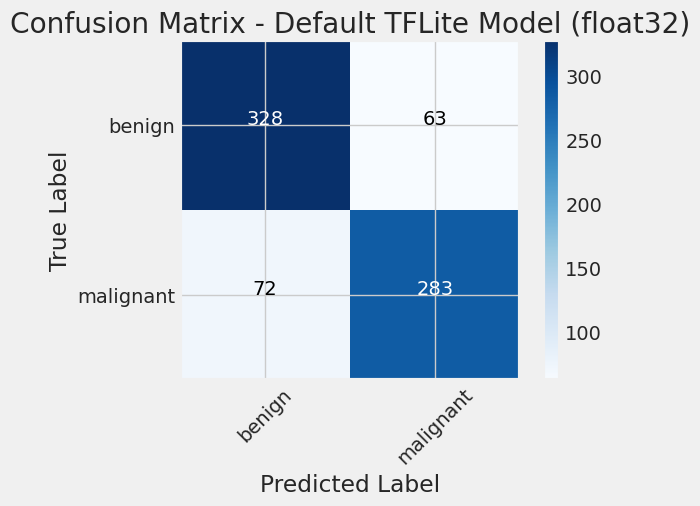


Classification Report (Default TFLite Model (float32)):
              precision    recall  f1-score   support

      benign       0.82      0.84      0.83       391
   malignant       0.82      0.80      0.81       355

    accuracy                           0.82       746
   macro avg       0.82      0.82      0.82       746
weighted avg       0.82      0.82      0.82       746


--- Evaluating FP16 Quantized TFLite Model ---
TFLite model 'FP16 Quantized TFLite Model' expects input shape: [  1 224 224   3]
Iterating TFLite evaluation dataset for FP16 Quantized TFLite Model using 24 steps.

FP16 Quantized TFLite Model Evaluation Results:
  Accuracy: 0.8190, AUC: 0.9081, Precision: 0.8179, Recall: 0.7972
  Average Inference Time: 516.09 ms/image


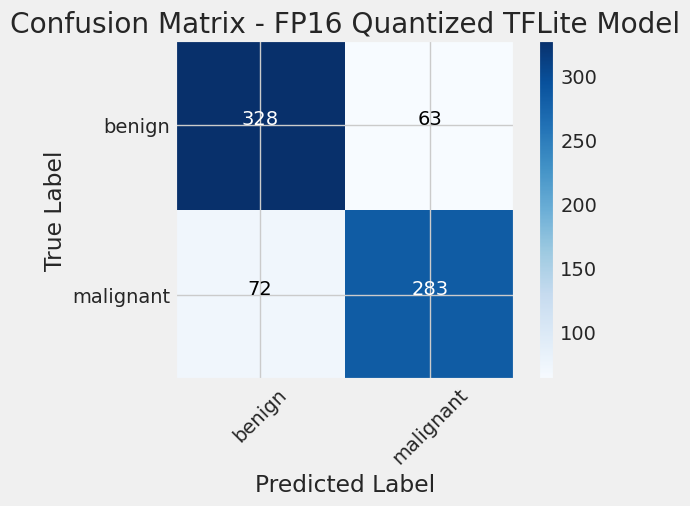


Classification Report (FP16 Quantized TFLite Model):
              precision    recall  f1-score   support

      benign       0.82      0.84      0.83       391
   malignant       0.82      0.80      0.81       355

    accuracy                           0.82       746
   macro avg       0.82      0.82      0.82       746
weighted avg       0.82      0.82      0.82       746



In [19]:
# Section 12: Model Conversion to TFLite & FP16 Quantization & Evaluation

import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt # For plotting CM
import itertools # For CM plotting
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score # For TFLite eval

# Ensure global constants that this cell might depend on are defined:
# Example: BATCH_SIZE (used for calculating steps for evaluation datasets)
# Example: test_df (pandas DataFrame, used for len(test_df) to get num_eval_samples)
# Example: test_dataset_tf (the tf.data.Dataset object for evaluation)
# Example: MODEL_SAVE_PATH (path to your best .keras model)
# Example: PositionEmbedding (the custom layer class definition must be in scope)

# --- Configuration for TFLite ---
TFLITE_MODEL_DIR = "/kaggle/working/tflite_models/" # Or your preferred output directory
os.makedirs(TFLITE_MODEL_DIR, exist_ok=True)
TFLITE_MODEL_PATH_DEFAULT = os.path.join(TFLITE_MODEL_DIR, "ccn_vit_binary_default_final.tflite")
TFLITE_MODEL_PATH_FP16 = os.path.join(TFLITE_MODEL_DIR, "ccn_vit_binary_fp16_final.tflite")

# --- Step 0: Helper function for plotting CM ---
def plot_colored_confusion_matrix(cm, class_names, plot_title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(plot_title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- Step 1: Load your trained Keras model ---
# MODEL_SAVE_PATH should be defined in Section 9 (e.g., "/kaggle/working/ccn_vit_binary_tfdata_best_v2.keras")
loaded_keras_model_for_tflite = None
if 'MODEL_SAVE_PATH' not in locals() or MODEL_SAVE_PATH is None:
    print("ERROR: MODEL_SAVE_PATH is not defined. Cannot load Keras model.")
else:
    try:
        # Ensure PositionEmbedding class is defined in a previous cell and has been run
        custom_objects_for_load = {'PositionEmbedding': PositionEmbedding}
        loaded_keras_model_for_tflite = tf.keras.models.load_model(MODEL_SAVE_PATH, custom_objects=custom_objects_for_load)
        print(f"Successfully loaded trained Keras model from: {MODEL_SAVE_PATH} for TFLite conversion.")
    except NameError as ne:
        print(f"NameError during model loading: {ne}. 'PositionEmbedding' class might not be defined or accessible.")
        print("Please ensure the cell defining 'PositionEmbedding' has been run.")
    except Exception as e:
        print(f"Error loading Keras model from {MODEL_SAVE_PATH}: {e}.")
        if 'ccn_vit_model' in locals() and ccn_vit_model is not None:
            loaded_keras_model_for_tflite = ccn_vit_model
            print("Using 'ccn_vit_model' from memory for TFLite conversion (this might not be the best performing one).")
        else:
            print("ERROR: Trained Keras model could not be loaded from file or found in memory for TFLite conversion.")

if loaded_keras_model_for_tflite:
    # --- Step 2: Convert to TensorFlow Lite (Default - float32) ---
    print("\n--- Converting to TensorFlow Lite (float32) ---")
    try:
        converter_default = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model_for_tflite)
        tflite_model_default_content = converter_default.convert()
        with open(TFLITE_MODEL_PATH_DEFAULT, 'wb') as f:
            f.write(tflite_model_default_content)
        print(f"Default TFLite model saved to: {TFLITE_MODEL_PATH_DEFAULT}, Size: {os.path.getsize(TFLITE_MODEL_PATH_DEFAULT) / (1024 * 1024):.2f} MB")
    except Exception as e:
        print(f"Error during default TFLite conversion: {e}")
        TFLITE_MODEL_PATH_DEFAULT = None # Mark as failed to prevent usage

    # --- Step 3: Convert to TensorFlow Lite with FP16 Quantization ---
    print("\n--- Converting to TensorFlow Lite with FP16 Quantization ---")
    try:
        converter_fp16 = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model_for_tflite)
        converter_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
        converter_fp16.target_spec.supported_types = [tf.float16]
        tflite_model_fp16_content = converter_fp16.convert()
        with open(TFLITE_MODEL_PATH_FP16, 'wb') as f:
            f.write(tflite_model_fp16_content)
        print(f"FP16 Quantized TFLite model saved to: {TFLITE_MODEL_PATH_FP16}, Size: {os.path.getsize(TFLITE_MODEL_PATH_FP16) / (1024 * 1024):.2f} MB")
    except Exception as e:
        print(f"Error during FP16 TFLite conversion: {e}")
        TFLITE_MODEL_PATH_FP16 = None # Mark as failed

# --- Step 4: Helper function to evaluate TFLite model using tf.data.Dataset ---
def evaluate_tflite_model_tfdata(tflite_model_path_eval, tf_eval_dataset_obj, num_eval_samples_val, batch_size_val, model_name_val="TFLite Model"):
    if not tflite_model_path_eval or not os.path.exists(tflite_model_path_eval):
        print(f"TFLite model file not found or path is None for {model_name_val} at '{tflite_model_path_eval}'. Skipping evaluation.")
        return
    if tf_eval_dataset_obj is None:
        print(f"Evaluation dataset for {model_name_val} is None. Skipping evaluation.")
        return
    if num_eval_samples_val is None or batch_size_val is None:
        print(f"num_eval_samples or batch_size not provided for {model_name_val}. Skipping evaluation.")
        return


    print(f"\n--- Evaluating {model_name_val} ---")
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path_eval)
    try:
        interpreter.allocate_tensors()
    except Exception as e_alloc:
        print(f"Error allocating TFLite tensors for {model_name_val}: {e_alloc}")
        return
        
    input_details_eval = interpreter.get_input_details()
    output_details_eval = interpreter.get_output_details()
    print(f"TFLite model '{model_name_val}' expects input shape: {input_details_eval[0]['shape']}")

    y_true_list_tflite_eval, y_pred_probs_list_tflite_eval, inference_times_tflite_eval = [], [], []
    # For a repeating dataset, steps must be provided to iterate once
    steps_to_iterate_tflite_eval = int(np.ceil(num_eval_samples_val / batch_size_val))
    print(f"Iterating TFLite evaluation dataset for {model_name_val} using {steps_to_iterate_tflite_eval} steps.")

    processed_samples_count = 0
    for images_batch_tflite, labels_batch_tflite in tf_eval_dataset_obj.take(steps_to_iterate_tflite_eval):
        y_true_list_tflite_eval.extend(labels_batch_tflite.numpy())
        for i in range(images_batch_tflite.shape[0]):
            if processed_samples_count >= num_eval_samples_val:
                break # Ensure we don't process more than num_eval_samples due to batching

            single_image_tflite = np.expand_dims(images_batch_tflite[i], axis=0)
            if single_image_tflite.dtype != np.float32:
                 single_image_tflite = single_image_tflite.astype(np.float32)
            
            interpreter.set_tensor(input_details_eval[0]['index'], single_image_tflite)
            start_time_tflite = time.time()
            interpreter.invoke()
            inference_times_tflite_eval.append(time.time() - start_time_tflite)
            output_data_tflite = interpreter.get_tensor(output_details_eval[0]['index'])
            y_pred_probs_list_tflite_eval.append(output_data_tflite[0][0])
            processed_samples_count += 1
        if processed_samples_count >= num_eval_samples_val:
            break
            
    y_true_tflite_eval = np.array(y_true_list_tflite_eval)[:num_eval_samples_val]
    y_pred_probs_tflite_eval = np.array(y_pred_probs_list_tflite_eval)[:num_eval_samples_val]
    
    if len(y_true_tflite_eval) == 0 or len(y_pred_probs_tflite_eval) == 0 or len(y_true_tflite_eval) != len(y_pred_probs_tflite_eval):
        print(f"Length mismatch or empty arrays after data collection for {model_name_val}. True: {len(y_true_tflite_eval)}, Pred_Probs: {len(y_pred_probs_tflite_eval)}. Skipping metrics calculation.")
        return

    y_pred_classes_tflite_eval = (y_pred_probs_tflite_eval > 0.5).astype(int)

    accuracy_tflite_eval = np.mean(y_pred_classes_tflite_eval == y_true_tflite_eval)
    try:
        auc_tflite_eval = roc_auc_score(y_true_tflite_eval, y_pred_probs_tflite_eval)
        precision_tflite_eval = precision_score(y_true_tflite_eval, y_pred_classes_tflite_eval, zero_division=0)
        recall_tflite_eval = recall_score(y_true_tflite_eval, y_pred_classes_tflite_eval, zero_division=0)
    except ValueError as e_met_tflite: 
        print(f"Metric calculation error for {model_name_val} (possibly all one class predictions or NaN in probs): {e_met_tflite}")
        auc_tflite_eval, precision_tflite_eval, recall_tflite_eval = -1, -1, -1
        
    avg_inference_time_ms_tflite_eval = (np.mean(inference_times_tflite_eval) * 1000) if inference_times_tflite_eval else 0

    print(f"\n{model_name_val} Evaluation Results:")
    print(f"  Accuracy: {accuracy_tflite_eval:.4f}, AUC: {auc_tflite_eval:.4f}, Precision: {precision_tflite_eval:.4f}, Recall: {recall_tflite_eval:.4f}")
    print(f"  Average Inference Time: {avg_inference_time_ms_tflite_eval:.2f} ms/image")
    
    cm_tflite_eval = confusion_matrix(y_true_tflite_eval, y_pred_classes_tflite_eval)
    class_names_for_cm = ['benign', 'malignant'] # Make sure this order matches your 0 and 1
    plot_colored_confusion_matrix(cm_tflite_eval, class_names_for_cm, plot_title=f'Confusion Matrix - {model_name_val}')
    print(f"\nClassification Report ({model_name_val}):")
    print(classification_report(y_true_tflite_eval, y_pred_classes_tflite_eval, target_names=class_names_for_cm, zero_division=0))


# --- Step 5: Evaluate the TFLite models ---
# Ensure test_dataset_tf (tf.data.Dataset), test_df (pandas DataFrame for len), and BATCH_SIZE are defined
if loaded_keras_model_for_tflite: # Only proceed if Keras model was available for conversion
    if 'test_dataset_tf' in locals() and test_dataset_tf is not None and \
       'test_df' in locals() and test_df is not None and \
       'BATCH_SIZE' in locals() and BATCH_SIZE is not None:
        
        if TFLITE_MODEL_PATH_DEFAULT and os.path.exists(TFLITE_MODEL_PATH_DEFAULT):
            evaluate_tflite_model_tfdata(TFLITE_MODEL_PATH_DEFAULT, test_dataset_tf, len(test_df), BATCH_SIZE, model_name_val="Default TFLite Model (float32)")
        else:
            print("Default TFLite model file not found or not created. Skipping its evaluation.")
            
        if TFLITE_MODEL_PATH_FP16 and os.path.exists(TFLITE_MODEL_PATH_FP16):
            evaluate_tflite_model_tfdata(TFLITE_MODEL_PATH_FP16, test_dataset_tf, len(test_df), BATCH_SIZE, model_name_val="FP16 Quantized TFLite Model")
        else:
            print("FP16 TFLite model file not found or not created. Skipping its evaluation.")
    else:
        print("Test data (test_dataset_tf, test_df, or BATCH_SIZE) not available. Skipping TFLite model evaluation.")
else:
    print("Keras model was not loaded/available for TFLite. Skipping all TFLite conversion and evaluation steps.")